In [1]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('sales_train_v2.csv')

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                ((df_sales['item_id']==969)) &
                               (df_sales['date_block_num']<34)]

df_sales_fbprophet = df_sales_fbprophet.drop(['date','shop_id','item_id','item_price'],axis=1)
df_sales_fbprophet

,date_block_num,item_cnt_day
1706796,17,1.0
1706797,17,1.0
1706798,17,2.0
1707992,17,1.0
1707993,17,1.0
...,...,...
2864963,32,2.0
2872078,32,1.0
2885178,33,1.0
2905122,33,1.0


In [4]:
# date_block_num - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
df_sales_fbprophet['date_month'] = datetime.datetime(2013, 1, 1).date() + df_sales_fbprophet['date_block_num'].apply(pd.offsets.MonthEnd) 
df_sales_fbprophet = df_sales_fbprophet.groupby(['date_month'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')
df_sales_fbprophet

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,date_month,item_cnt_month
0,2014-05-31,128.0
1,2014-06-30,64.0
2,2014-07-31,35.0
3,2014-08-31,14.0
4,2014-09-30,8.0
5,2014-10-31,6.0
6,2014-11-30,7.0
7,2014-12-31,9.0
8,2015-01-31,7.0
9,2015-02-28,8.0


In [5]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date_month": "ds", "item_cnt_month": "y"})
df_sales_fbprophet

,ds,y
0,2014-05-31,128.0
1,2014-06-30,64.0
2,2014-07-31,35.0
3,2014-08-31,14.0
4,2014-09-30,8.0
5,2014-10-31,6.0
6,2014-11-30,7.0
7,2014-12-31,9.0
8,2015-01-31,7.0
9,2015-02-28,8.0


In [6]:
# put in limits
df_sales_fbprophet['floor']=0
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()

In [7]:
m = Prophet(growth='logistic')
m.fit(df_sales_fbprophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 12.


In [8]:
# predict 2 months into the future
future = m.make_future_dataframe(periods=2, freq='M')
future['floor']=0
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
14,2015-07-31,0,128.0
15,2015-08-31,0,128.0
16,2015-09-30,0,128.0
17,2015-10-31,0,128.0
18,2015-11-30,0,128.0


In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
14,2015-07-31,0.000183,-9.946317,10.906935
15,2015-08-31,0.000062,-10.423989,10.046793
16,2015-09-30,0.000022,-9.998261,9.724501
17,2015-10-31,0.000007,-10.547359,10.151106
18,2015-11-30,0.000003,-9.958703,9.912148


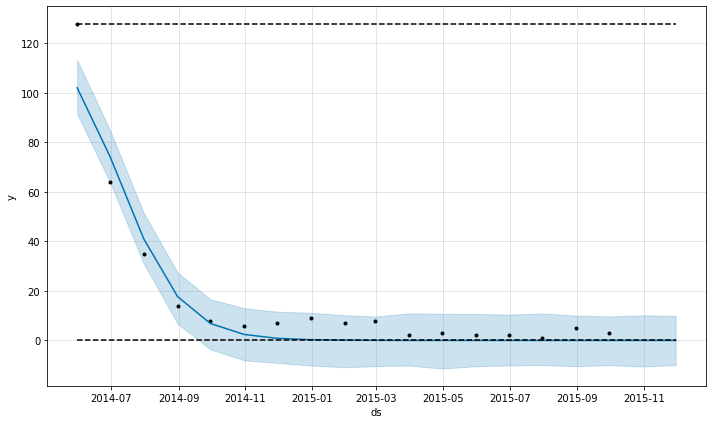

In [10]:
fig1 = m.plot(forecast)

In [11]:
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-05-31,102.124344,128.0,0,91.541350,113.352628,102.124344,102.124344,0.0,0.0,0.0,0.0,0.0,0.0,102.124344
1,2014-06-30,74.422736,128.0,0,64.106113,85.062551,74.422736,74.422736,0.0,0.0,0.0,0.0,0.0,0.0,74.422736
2,2014-07-31,41.053315,128.0,0,31.046219,51.475281,41.053315,41.053315,0.0,0.0,0.0,0.0,0.0,0.0,41.053315
3,2014-08-31,17.702373,128.0,0,6.742913,27.450479,17.702373,17.702373,0.0,0.0,0.0,0.0,0.0,0.0,17.702373
4,2014-09-30,6.843813,128.0,0,-3.582575,16.643038,6.843813,6.843813,0.0,0.0,0.0,0.0,0.0,0.0,6.843813
5,2014-10-31,2.411419,128.0,0,-8.027020,13.042334,2.411419,2.411419,0.0,0.0,0.0,0.0,0.0,0.0,2.411419
6,2014-11-30,0.859201,128.0,0,-9.077028,11.620347,0.859201,0.859201,0.0,0.0,0.0,0.0,0.0,0.0,0.859201
7,2014-12-31,0.293355,128.0,0,-10.120744,11.173163,0.293355,0.293355,0.0,0.0,0.0,0.0,0.0,0.0,0.293355
8,2015-01-31,0.099867,128.0,0,-10.825287,10.215400,0.099867,0.099867,0.0,0.0,0.0,0.0,0.0,0.0,0.099867
9,2015-02-28,0.037701,128.0,0,-10.374663,9.672129,0.037701,0.037701,0.0,0.0,0.0,0.0,0.0,0.0,0.037701
